# Analyzing transposon insertions from SATAY

This code analyzes the number and location of all insertions per gene to predict essential genes from satay data.

It uses the .bam_pergene_insertions.txt file which is an output from SATAY processing workflow in Linux.

## Load packages

In [68]:
import os, sys
import copy
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.cbook import boxplot_stats

dirname = os.path.dirname(os.path.abspath('__file__'))
print('Directory current file: %s' % dirname)
sys.path.insert(1,os.path.join(dirname,"python_modules"))
from gene_names import gene_aliases

Directory current file: c:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts


## Open datafiles

In [61]:
filepath = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt1_testfolder\align_out"
filename = "ERR1533148_trimmed.sorted.bam_pergene_insertions.txt"
#    filepath = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt2_testfolder\WT2_dataset_analysis_temp202008051429_new2"
#    filename = r"E-MTAB-4885.WT2.bam_pergene_insertions.txt"
datafile = os.path.join(filepath, filename)

essentialsfile = os.path.join(dirname,"Data_Files","Cerevisiae_AllEssentialGenes_List.txt")

## Get insertions and reads for all genes

In [62]:
with open(datafile) as f:
    lines = f.readlines()


gene_position_dict = {}
gene_inserts_dict = {}
gene_reads_dict = {}

gene_inserts_distance_dict = {} #distance between subsequent inserts
gene_inserts_trunc_dict = {} #inserts in the gene where 10% of the edges is truncated (so, only the center part of the gene is considered).
gene_reads_trunc_dict = {} #reads in the gene where 10% of the edges is truncated (so, only the center part of the gene is considered).
for line in lines[1:]:
    line_split = line.strip('\n').split('\t')
    genename = line_split[0]
    gene_chrom = line_split[1]
    gene_start = int(line_split[2])
    gene_end = int(line_split[3])


    gene_position_dict[genename] = [gene_chrom, gene_start, gene_end]


    geneinserts_str = line_split[4].strip('[]')
    if not geneinserts_str == '':
        geneinserts_list = [int(ins) for ins in geneinserts_str.split(',')]
    else:
        geneinserts_list = []
    gene_inserts_dict[genename] = geneinserts_list


    ins_list = []
    ins_indx_list = []
    for ins in geneinserts_list: #GET INSERTIONS THAT ARE MORE THAN 10% OF LENGTH GENE AWAY FROM THE EDGES OF THE GENE.
        l = gene_end - gene_start
        if (gene_start + 0.1*l) < ins < (gene_end - 0.1*l):
            ins_list.append(ins)
            ins_indx_list.append(geneinserts_list.index(ins))
    gene_inserts_trunc_dict[genename] = ins_list


    if not len(geneinserts_list) < 2:
        d = []
        for i in range(1,len(geneinserts_list)): #DISTANCES BETWEEN SUBSEQUENT INSERTS
            d.append(geneinserts_list[i] - geneinserts_list[i-1])
        gene_inserts_distance_dict[genename] = d
    elif len(geneinserts_list) == 1:
        gene_inserts_distance_dict[genename] = [0]#[0] #only one insert
    else:
        gene_inserts_distance_dict[genename] = [0]#[-1] #no insert


    genereads_str = line_split[5].strip('[]')
    if not genereads_str == '':
        genereads_list = [int(read) for read in genereads_str.split(',')]
    else:
        genereads_list = []
    gene_reads_dict[genename] = genereads_list
    gene_reads_trunc_dict[genename] = [genereads_list[i] for i in ins_indx_list]

    if len(geneinserts_list) != len(genereads_list):
        print('WARNING: %s has different number of reads compared with the number of inserts' % genename )



del (datafile, lines, line, line_split, genename, gene_chrom, gene_start, gene_end, geneinserts_str, geneinserts_list, genereads_str, genereads_list, i, d, ins, ins_list, ins_indx_list, l)
#remains: gene_inserts_dict, gene_position_dict, gene_reads_dict

## Split information in essential genes and nonessential genes

In [63]:
with open(essentialsfile) as f:
    lines = f.readlines()


aliases_dict = gene_aliases(os.path.join(dirname,"Data_Files","Yeast_Protein_Names.txt"))[0]


essential_position_dict = {}
essential_inserts_dict = {}
essential_reads_dict = {}

nonessential_position_dict = copy.deepcopy(gene_position_dict)
nonessential_inserts_dict = copy.deepcopy(gene_inserts_dict)
nonessential_reads_dict = copy.deepcopy(gene_reads_dict)


for line in lines[1:]:
    essential = line.strip('\n')


    essentiality = 'nonessential'


    if essential in gene_position_dict:
        essentiality = 'essential'
        alias = essential
    else:
        for alias in aliases_dict.get(essential):
            if alias in gene_position_dict:
                essentiality = 'essential'
                break


    if essentiality == 'essential':
        essential_position_dict[alias] = gene_position_dict.get(alias)
        essential_inserts_dict[alias] = gene_inserts_dict.get(alias)
        essential_reads_dict[alias] = gene_reads_dict.get(alias)
        
        del nonessential_position_dict[alias]
        del nonessential_inserts_dict[alias]
        del nonessential_reads_dict[alias]


del (essentialsfile, lines, line, aliases_dict, essential, essentiality, alias)
#remain: essential_position_dict, essential_inserts_dict, essential_reads_dict, nonessential_position_dict, nonessential_inserts_dict, nonessential_reads_dict


## Create dataframe for all genes

This includes the gene name, whether they are essential or not and some statistics about the genes regarding the transposon insertions.
When adding a statistic, initialize a new list, apply calculation in the for-loop and add the values to the initialized list. Add the list with a appropriate name to the 'allgenes' variable and put the list in line for deleting.

In [64]:
genename_list = []
essentiality_list = []
N_inserts_list = []
N_inserts_trunc_list = []
N_reads_trunc_list = []
distance_max_inserts_list = []
N_reads_list = []
for gene in gene_position_dict:
    genename_list.append(gene) #GENENAME LIST
    
    if gene in essential_position_dict: #ESSENTIALITY_LIST
        essentiality_list.append(True)
    elif gene in nonessential_position_dict:
        essentiality_list.append(False)
    else:
        print('WARNING: %s not found.' % gene)

    N_inserts_list.append(len(gene_inserts_dict.get(gene))) #N_INSERTS_LIST (NUMBER OF INSERTIONS)

    N_inserts_trunc_list.append(len(gene_inserts_trunc_dict.get(gene))) #N_INSERTS_CENTER_LIST (NUMBER OF INSERTIONS IN THE GENE WHERE 10% OF THE GENE LENGTH IS TRUNCATED)

    N_reads_trunc_list.append(sum(gene_reads_trunc_dict.get(gene)))

    distance_max_inserts_list.append(np.nanmax(gene_inserts_distance_dict.get(gene)) / (gene_position_dict.get(gene)[2] - gene_position_dict.get(gene)[1])) #DISTANCE_MAX_INSERTS_LIST (LARGEST DISTANCE BETWEEN SUBSEQUENT INSERTIONS NORMALIZED TO GENE LENGTH)
    
    N_reads_list.append(sum(gene_reads_dict.get(gene))) #N_READS_LIST (TOTAL NUMBER OF READS IN GENE)



allgenes = {'Gene_Name': genename_list,
            'Essentiality': essentiality_list,
            'Number_Insertions_Full_Gene': N_inserts_list,
            'Number_Insertions_Truncated_Gene': N_inserts_trunc_list,
            'Max_Insertion_Distance': distance_max_inserts_list,
            'Number_Reads_Full_Gene': N_reads_list,
            'Number_Reads_Truncated_Gene': N_reads_trunc_list}


df = pd.DataFrame(allgenes, columns = [column_name for column_name in allgenes])
print(df)

del (gene, genename_list, essentiality_list, N_inserts_list, N_inserts_trunc_list, distance_max_inserts_list, N_reads_list, N_reads_trunc_list, allgenes)


Gene_Name  Essentiality  Number_Insertions_Full_Gene  \
0       YAL069W         False                            5   
1     YAL068W-A         False                            2   
2          PAU8         False                            1   
3     YAL067W-A         False                            3   
4          SEO1         False                           16   
...         ...           ...                          ...   
6595       ARR3         False                            8   
6596    YPR202W         False                           26   
6597    YPR203W         False                           12   
6598    YPR204W         False                           80   
6599  YPR204C-A         False                            5   

      Number_Insertions_Truncated_Gene  Max_Insertion_Distance  \
0                                    5                0.207006   
1                                    2                0.444882   
2                                    1                0.000000 

## Showing the results from the dataframe.

For plotting, preferably use seaborn with the information stored in the dataframe variable 'df'.

In [65]:
sns.set(style="whitegrid")


### Plot number of insertions full gene length

*(Potentially useful for machine learning)*

This shows a boxplot for the number of insertions and number of reads for all genes. For each gene, all insertions are considered.
There are many outliers, both in the essential and nonessential genes, so for showing purposes the y-axis is limited for both the number of insertions and number of reads.
This shows that essential genes have, on average, few insertions and reads but there are many nonessential genes that also have little insertions and/or reads.
When a gene is encountered with little insertions, no conclusion can be drawn whether this gene is essential or not.

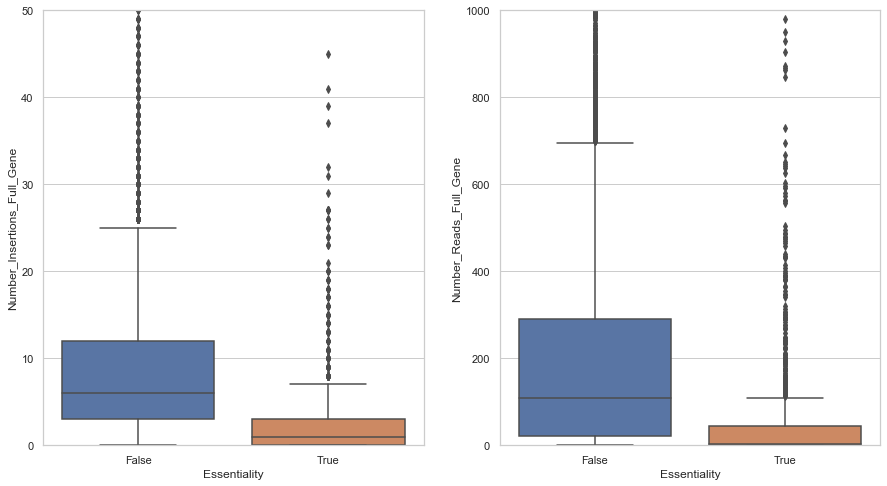

In [123]:
df_select = df[df['Number_Reads_Full_Gene'] < 10000]

fig = plt.figure(figsize=(15,8))
grid = plt.GridSpec(1,2)

ax1 = plt.subplot(grid[0,0])
sns.boxplot(x='Essentiality',y='Number_Insertions_Full_Gene',data=df, ax=ax1)
ax1.set(ylim=(0,50))

ax2 = plt.subplot(grid[0,1])
sns.boxplot(x='Essentiality',y='Number_Reads_Full_Gene', data=df_select, ax=ax2)
ax2.set(ylim=(0,1000))

del (fig, grid, ax1, ax2, df_select)

### Plot number of insertions truncated gene length

*(Potentially useful for machine learning)*

This shows the number of insertions for each gene, but only in the middle 80% of the genes.
For this the first 10% and last 10% of the gene is discarded when the number of insertions are counted.
This is useful as the for most essential genes, if they have insertions, they are more likely to be placed in the beginning or near the end of the gene.
This typically does not disrupt the function of the gene, but simply truncate the gene without interferring with the function of the gene.
Using this technique, a more clear distinction can be seen between the essential and nonessential genes.

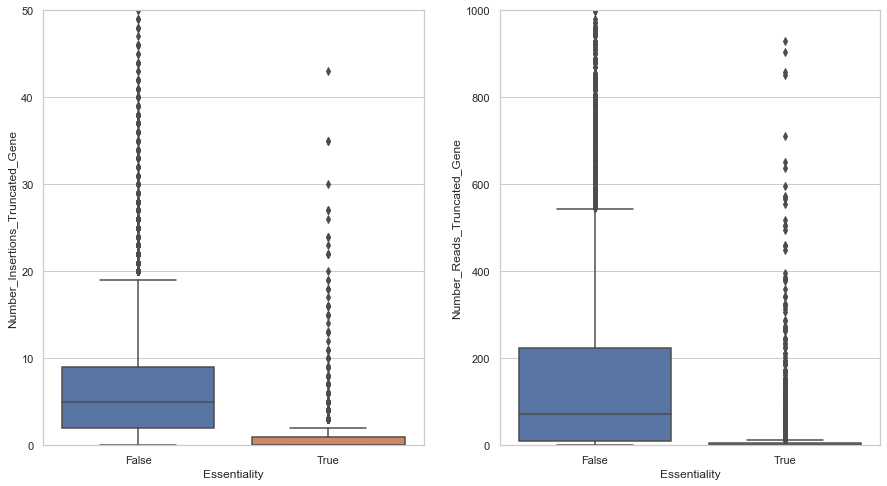

In [147]:
df_select = df[df['Number_Reads_Full_Gene'] < 10000]

fig = plt.figure(figsize=(15,8))
grid = plt.GridSpec(1,2)

ax1 = plt.subplot(grid[0,0])
sns.boxplot(x='Essentiality',y='Number_Insertions_Truncated_Gene',data=df, ax=ax1)
ax1.set(ylim=(0,50))

ax2 = plt.subplot(grid[0,1])
sns.boxplot(x='Essentiality',y='Number_Reads_Truncated_Gene', data=df_select, ax=ax2)
ax2.set(ylim=(0,1000))

del (fig, ax1, ax2, df_select)

### Plot distance between subsequent insertions in a gene

*(Not so useful (?))*

This shows the distribution of the distance between subsequent insertions.
The question is what to do with genes that 0 or 1 insertion.
If, for those genes, the distance is set to 0, there is a difference seen between the essential and nonessential genes (see left graph).
But how fair is it to do this?
Essential genes are more likely to have 0 or 1 insertions, so by setting the distances in these situations to 0 creates a bias in the distribution for the essential genes.
When these situations are ignored (right graph), the difference between the essential and nonessential genes is gone.

So, using this statistic might be a bit fishy and is therefore not recommended.

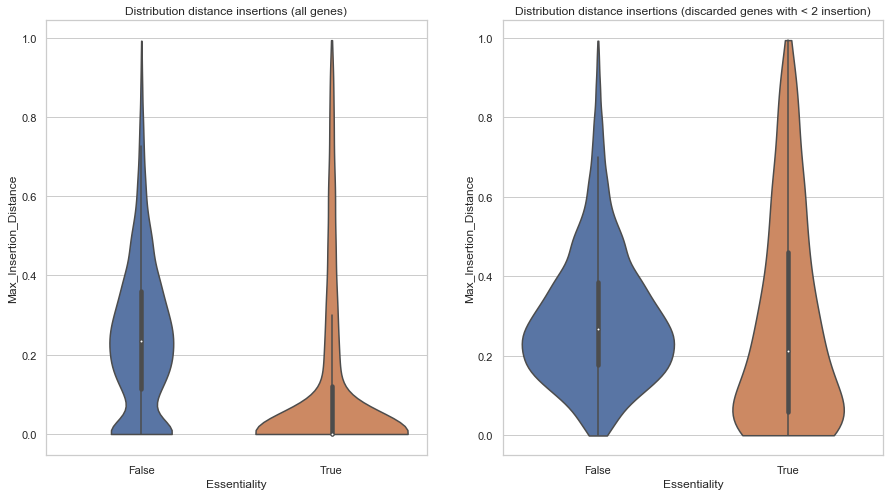

In [90]:
df_select = df[df['Number_Insertions_Full_Gene'] > 1]

fig, axes = plt.subplots(1,2, figsize=(15,8))
ax1 = sns.violinplot(x='Essentiality',y='Max_Insertion_Distance', data=df, cut=0, ax=axes[0])
ax1.set_title("Distribution distance insertions (all genes)")
ax2 = sns.violinplot(x='Essentiality',y='Max_Insertion_Distance', data=df_select, cut=0, ax=axes[1])
ax2.set_title("Distribution distance insertions (discarded genes with < 2 insertion)")

del (fig, axes, ax1, ax2, df_select)